In [15]:
from __future__ import print_function

# Optimisations pour les réseaux neuronaux profonds

## ReLU - Rectified Linear Unit

L'utilisation de la fonction sigmoïde peut s'avérer problématique car toutes les sorties des neurones sont comprises entre 0 et 1, ce qui peut amener à des sorties et des gradients qui deviennent non significatifs. On préfère dorénavant utiliser la fonction ReLU `tf.nn.relu`

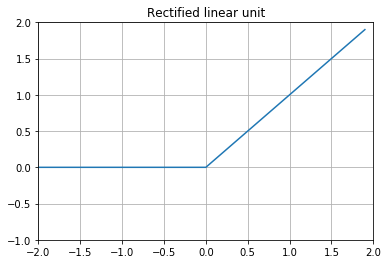

In [16]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-2, 2, .1)
zero = np.zeros(len(x))
y = np.max([zero, x], axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_ylim([-1.0, 2.0])
ax.set_xlim([-2.0, 2.0])
ax.grid(True)
ax.set_title('Rectified linear unit')

plt.show()

## Fonction d'optimisation

Il est possible aussi d'utiliser une meilleur fonction d'optimisation que le `tf.train.GradientDescentOptimiser` afin d'éviter les états d'équilibre où le gradient est nul mais la zone ne correspond pas à un minimum local (l'équivalent d'un col en montagne). On utilise une forme d'inertie pour passer ce genre de points comme par exemple avec la fonction `tf.train.AdamOptimizer`.

## Initialisation

En plus de l'initialisation aléatoire des poids selon une loi normale, il est d'usage d'initialiser l'ensemble des biais à une faible valeur positive (0.1 par exemple) lorsque l'on travaille avec ReLU comme fonction d'activation afin d'éviter de travailler dans la zone où la réponse reste égale à 0.

## Pas d'apprentissage dégressif

Il est aussi possible de faire décroître progressivement le pas d'apprentissage (learning rate) afin de diminuer la vitesse d'apprentissage lorsque l'on s'approche du minimum. `tf.train.exponential_decay`

On définit le pas initial, puis tous les x passages on multiplie par un taux.

$ learning\_rate = starter\_learning\_rate * decay\_rate^{\frac{global\_step}{decay\_steps}}$

La variable global_step indique combien de fois on exécute l'apprentissage. Quand le paramètre staircase=True, on fait une division entière dans la formule, ce qui permet une décroissance en escalier.

## Entropie croisée et log(0)

<img src="log_0.png"  style="width: 40%; height: 40%"/>

Pour de très faibles valeurs de Y, le calcul de l'entropie croisée implique un log sur les valeurs de sortie de la couche de neurones avec softmax.La formule a tendance à retourner des NaN (not a number) car elle essaie de calculer log(0). Au lieu de la fonction softmax classique on utilise la fonction `softmax_cross_entropy_with_logits_v2` qui permet de calculer à la fois softmax et l'entropie croisée de manière stable numériquement.

## Reformulation du réseau neuronal à 5 couches

## Imports et données

In [17]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.
x_test  = x_test/255.
y_train = to_categorical(y_train, dtype='int8')
y_test  = to_categorical(y_test, dtype='int8')

train_size = x_train.shape[0] # Nombre de ligne de la matrice x_train
test_size  = x_test.shape[0]

## Hyperparamètres

In [19]:
#Nombre d'époques pour l'apprentissage:
n_epoch = 16

# Taille du batch d'entraînement:
batch_size = 100

# Incrément pour l'apprentissage
starter_learning_rate = 0.003
# taux de décroissance du pas d'apprentissage
decay_rate = 0.5
# Nombre d'époques à faire avant de changer de pas
decay_epoch = 4

## Graphe

In [20]:
X = tf.placeholder(tf.float32, shape=(None,28,28))
Xv = tf.reshape(X, [-1, 784])

W1 = tf.Variable(tf.truncated_normal([784,200], stddev=0.1))
# Initialisation des biais 0.1
b1 = tf.Variable(tf.ones([200])/10)
Y1 = tf.nn.relu(tf.matmul(Xv,W1) + b1)

W2 = tf.Variable(tf.truncated_normal([200,100], stddev=0.1))
b2 = tf.Variable(tf.ones([100])/10)
Y2 = tf.nn.relu(tf.matmul(Y1,W2) + b2)

W3 = tf.Variable(tf.truncated_normal([100,60], stddev=0.1))
b3 = tf.Variable(tf.ones([60])/10)
Y3 = tf.nn.relu(tf.matmul(Y2,W3) + b3)

W4 = tf.Variable(tf.truncated_normal([60,30], stddev=0.1))
b4 = tf.Variable(tf.ones([30])/10)
Y4 = tf.nn.relu(tf.matmul(Y3,W4) + b4)

W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1))
b5 = tf.Variable(tf.zeros([10]))
Ylogits = tf.matmul(Y4,W5) + b5
Y = tf.nn.softmax(Ylogits)

In [21]:
Y_ = tf.placeholder(tf.float32, shape=(None,10))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_sum(cross_entropy)

is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

# Pas d'apprentissage décroissant
- diminution de `decay_rate` toutes les `decay_epoch` époques soit `decay_epoch*train_size//batch_size` batchs vus
- `global_step` est incrémenté de 1 à chaque batch vu

In [22]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_epoch*train_size//batch_size, decay_rate, staircase=True)

# Changement de fonction d'optimisation
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy, global_step=global_step)

## Entraînement

In [26]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
i_best = 0
accuracy_best = 0

In [27]:
# Tableau pour la visualisation de l'évolution du pas d'apprentissage
lr_train = []

In [28]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
print('Epoque: ')

for i in range(n_epoch*train_size//100):
    epoch = (i*100)//train_size + 1
    
    # Chargement d'un batch d'images et de réponses correctes correspondantes
    batch_train_X  = x_train[(i*100)%train_size:((i+1)*100)%train_size]
    batch_train_Y_ = y_train[(i*100)%train_size:((i+1)*100)%train_size]
    # Dictionnaire de données en entrée
    train_data = {X: batch_train_X, Y_: batch_train_Y_}

    # train
    sess.run(train_step, feed_dict=train_data)
    
    # Visualisation de la progression
    if not (i*100)%(train_size):
        #Affichage de l'évolution en ligne
        print(epoch, ' ', end='')
    if not i%50:
        # Pour le batch d'entraînement
        acc, loss, lr = sess.run([accuracy, cross_entropy, learning_rate], feed_dict=train_data)
        accuracy_train.append(acc)
        loss_train.append(loss/batch_size)
        lr_train.append(lr)
        
        # Pour le test: évaluation sur tout l'ensemble des données
        test_data = {X: x_test, Y_: y_test}
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
        accuracy_test.append(acc)
        loss_test.append(loss/test_size)
        if acc>accuracy_best:
            accuracy_best = acc
            i_best = i

Epoque: 
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  

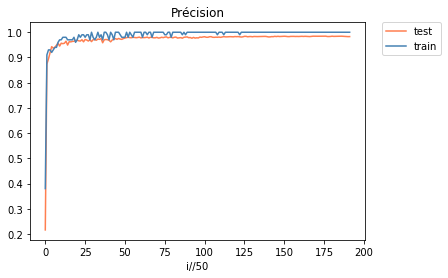

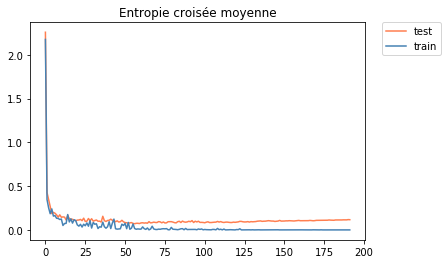

Best score for iteration 8800 	| Accuracy = 0.9844


In [29]:
# Représentation des résultats
# Précision
plt.plot(accuracy_test, c='coral', label='test')
plt.plot(accuracy_train, c='steelblue', label='train')
plt.xlabel('i//50')
plt.title('Précision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Fonction de coût
plt.plot(loss_test, c='coral', label='test')
plt.plot(loss_train, c='steelblue', label='train')
plt.title('Entropie croisée moyenne')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Meilleur résultat sur un batch de test
print("Best score for iteration {} \t| Accuracy = {:.4f}".format(i_best, accuracy_best ))

Meilleure précision au bout de 8800 itérations: 98,4. Légèrement variable d'un coup à l'autre, certainement dû aux conditions initiales définies aléatoirement.

In [30]:
sess.close()

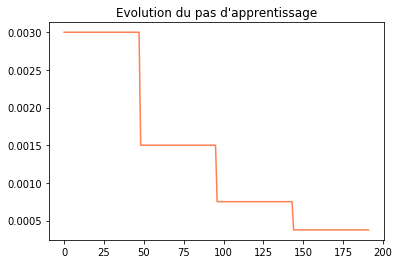

In [31]:
plt.title('Evolution du pas d\'apprentissage')
plt.plot(lr_train, c='coral')
plt.show()